In [21]:
import itertools
import re
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


In [22]:
data = pd.read_csv('data/df_ml.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)
data.drop('vote_count', axis=1, inplace=True)
df = data.copy()
df.head()

,id,title,vote_average,overview
0,19404,Dilwale Dulhania Le Jayenge,9.1,"Raj is a rich, carefree, happy-go-lucky second..."
1,278,The Shawshank Redemption,8.5,Framed in the 1940s for the double murder of h...
2,238,The Godfather,8.5,"Spanning the years 1945 to 1955, a chronicle o..."
3,372058,Your Name.,8.5,High schoolers Mitsuha and Taki are complete s...
4,155,The Dark Knight,8.3,Batman raises the stakes in his war on crime. ...


In [23]:
stopwords = nltk.corpus.stopwords.words('english')
filtrar = []
if True:
    filtrar.append("u")
    filtrar.append("new")
    filtrar.append("The")
    filtrar.append("In")
    filtrar.append("A")

In [24]:
lista = []
for i in range(df.shape[0]):
    titular = df.iloc[i, -1]
    titular = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(titular)
    titular = [word for word in titular if word not in stopwords]
    titular = [word for word in titular if word not in filtrar]

    lista.append(titular)

In [25]:
lista = list(itertools.chain(*lista))
lista[0:10]

['Raj',
 'rich',
 'carefree',
 'happy',
 'go',
 'lucky',
 'second',
 'generation',
 'NRI',
 'Simran']

In [26]:
freq_peliculas =nltk.FreqDist(lista)
freq_peliculas

FreqDist({'life': 319, 'world': 270, 'When': 266, 'one': 233, 'But': 225, 'young': 221, 'must': 215, 'find': 208, 'family': 199, 'man': 188, ...})

In [27]:
palabras_peliculas = pd.DataFrame(list(freq_peliculas.items()), columns=['palabra', 'frecuencia'])
palabras_peliculas.head()

,palabra,frecuencia
0,Raj,2
1,rich,17
2,carefree,5
3,happy,14
4,go,70


In [28]:
palabras_peliculas.sort_values('frecuencia', ascending=False, inplace=True)
palabras_peliculas.head(15)

,palabra,frecuencia
46,life,319
254,world,270
80,When,266
109,one,233
108,But,225
237,young,221
123,must,215
150,find,208
32,family,199
196,man,188


In [29]:
palabras_peliculas.reset_index(drop=True, inplace=True)

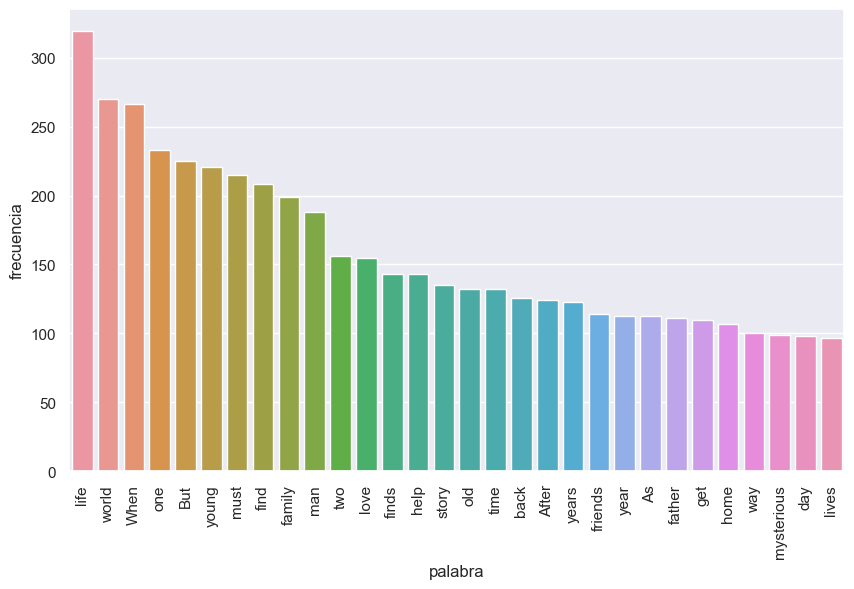

In [30]:
plt.figure(figsize=(10,6))
plot = sns.barplot(x = palabras_peliculas.iloc[:30].palabra, y=palabras_peliculas.iloc[:30].frecuencia)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

In [31]:
lemmatizer = WordNetLemmatizer()


In [32]:
def preprocesamiento(texto):
    texto = texto.lower()
    texto = re.sub(r'[^a-zA-Z]', ' ', texto)
    tokens = texto.split()
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stopwords]
    texto_procesado = ' '.join(tokens)
    return texto_procesado

In [33]:
df['pp_ov'] = df['overview'].apply(preprocesamiento)


In [34]:
df.head()

,id,title,vote_average,overview,pp_ov
0,19404,Dilwale Dulhania Le Jayenge,9.1,"Raj is a rich, carefree, happy-go-lucky second...",raj rich carefree happy go lucky second genera...
1,278,The Shawshank Redemption,8.5,Framed in the 1940s for the double murder of h...,framed double murder wife lover upstanding ban...
2,238,The Godfather,8.5,"Spanning the years 1945 to 1955, a chronicle o...",spanning year chronicle fictional italian amer...
3,372058,Your Name.,8.5,High schoolers Mitsuha and Taki are complete s...,high schoolers mitsuha taki complete stranger ...
4,155,The Dark Knight,8.3,Batman raises the stakes in his war on crime. ...,batman raise stake war crime help lt jim gordo...


In [35]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['pp_ov'])

In [36]:
similarity_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)


In [37]:
def get_recommendations(nombre_pelicula, similarity_matrix, num_recommendations=5):
    movie_index = data[data['title'] == nombre_pelicula].index[0]
    similarity_scores = list(enumerate(similarity_matrix[movie_index]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    top_scores = similarity_scores[1:num_recommendations+1]
    top_movie_indices = [score[0] for score in top_scores]
    top_movies = data['title'].iloc[top_movie_indices]
    dicc = {}
    for i, v in enumerate(top_movies.values):
        dicc[i + 1] = v
    return dicc

In [38]:
recommended_movies = get_recommendations('Titanic', similarity_matrix)
print(recommended_movies)

{1: 'The Legend of 1900', 2: 'Ghost Ship', 3: 'Event Horizon', 4: 'Boyhood', 5: 'Deepwater Horizon'}


In [39]:
import pickle

# Guardar la matriz de similitud en un archivo
with open('pickle/similarity_matrix.pkl', 'wb') as file:
    pickle.dump(similarity_matrix, file)